# Análise Exploratória dos Dados (EDA) - Rede de Citações


Além da biblioteca `networkx`, vamos utilizar o [Gephi](https://gephi.org/).

#### Carregando bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
pal = 'GnBu_d'
%matplotlib inline

import networkx as nx
from collections import Counter

import gc
import os

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#offline.init_notebook_mode()

from IPython.html.widgets import * # interact

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

path = os.getcwd()

/Users/acwgdb/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



#### Importando os dados

In [2]:
citations = pd.read_csv('outputs/citations.csv', index_col=0, encoding = "ISO-8859-1")
journals_cit = pd.read_csv('outputs/journals_cit.csv', index_col=0, encoding = "ISO-8859-1")
articles_cit = pd.read_csv('outputs/articles_cit.csv', index_col=0, encoding = "ISO-8859-1")

In [3]:
# Informações sobre as citações
citations.head()

,SOURCE_A,SOURCE_J,TARGET_A,TARGET_J,YEAR
1,WOS:000418951400033,1553-734X,WOS:A1997XU79300002,0305-1048,2017
2,WOS:000418951400033,1553-734X,WOS:000382258600111,1932-6203,2017
3,WOS:000418951400033,1553-734X,WOS:000354024900017,0969-2126,2017
4,WOS:000418951400033,1553-734X,WOS:000176271000003,0907-4449,2017
5,WOS:000418951400033,1553-734X,WOS:000084896300069,0305-1048,2017


In [4]:
# Informações sobre os periódicos da rede de citações
journals_cit.head()

,TITLE,CITED_OUT,CITED_IN,TOT_ART
ISSN,,,,
1553-734X,PLoS Computational Biology,224085.0,12190.0,4088.0
1367-4803,BIOINFORMATICS,132071.0,52320.0,5840.0
1752-0509,BMC Systems Biology,65446.0,4328.0,1443.0
1471-2105,BMC BIOINFORMATICS,149982.0,22495.0,4742.0
0303-6812,JOURNAL OF MATHEMATICAL BIOLOGY,27093.0,6551.0,845.0


In [5]:
# Informações sobre os artigos da rede de citações
articles_cit.head()

,ID_WOS,TITLE,JOURNAL_ID,YEAR,CITED_IN,CITED_OUT,CITED_OUT_OB,CITED_OUT_T
1,WOS:000418951400033,High-resolution global peptide-protein docking...,1,2017,0,62,3,62
2,WOS:000418951400005,A cyber-linked undergraduate research experien...,1,2017,0,34,7,47
3,WOS:000418951400031,Physiological models of the lateral superior o...,1,2017,0,170,3,185
4,WOS:000418951400028,MAGPIE: Simplifying access and execution of co...,1,2017,0,24,3,28
5,WOS:000418951400009,Stabilizing patterns in time: Neural network a...,1,2017,0,26,5,30


In [6]:
# Separandao as citações que estão fora da base
df_citations_out = citations[citations.TARGET_A == 'FORA DA BASE']
df_citations = citations[citations.TARGET_A != 'FORA DA BASE']

### Quantidade de artigos "FORA DA BASE"

Como a quantidade de artigos fora da base do WoS é baixa (aproximadanente 10% dos dados), vamos trabalhar apenas com os artigos pertencentes à base. 

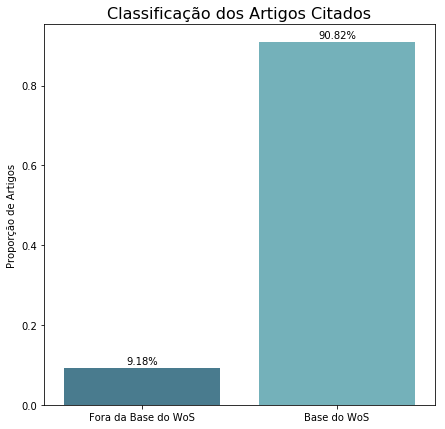

In [7]:
fora_da_base = (len(df_citations_out)/len(df_citations['TARGET_A']))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
sns.barplot(['Fora da Base do WoS', 'Base do WoS'], [fora_da_base,1-fora_da_base], palette=pal)
ax.set_title('Classificação dos Artigos Citados')
ax.title.set_size(16)
ax.set_ylabel('Proporção de Artigos')
for p, uniq in zip(ax.patches,[fora_da_base,1-fora_da_base]):
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.01, '{}%'.format(round(uniq * 100, 2)), ha="center")

## Quantos periódicos "surgiram"? Quantos periódicos "morreram"?

A princípio, vamos analisar a variação da quantidade de periódicos submetíveis por ano da categoria escolhida. 

In [8]:
years = list(df_citations.YEAR.unique())[::-1]
counts = []
news = []
deaths = []
issn_news = set()
issn_deaths = set()

for year in years:
    count = len(set(df_citations[df_citations.YEAR == year].SOURCE_J))
    if year == years[0]:
        new = set()
        death = set()
    else:
        death = set(df_citations[df_citations.YEAR == year-1].SOURCE_J) - set(df_citations[df_citations.YEAR == year].SOURCE_J)
        new = set(df_citations[df_citations.YEAR == year].SOURCE_J) - set(df_citations[df_citations.YEAR == year-1].SOURCE_J)
    issn_news.update(new)
    issn_deaths.update(death)
    counts.append(count-len(new)+len(death))
    news.append(len(new))
    deaths.append(-len(death))

In [9]:
trace1 = go.Bar(
    x=[str(i) for i in range(2010,2017)],
    y=news,
    name='Periódicos Adicionados',
    marker=dict(color='rgba(50, 171, 96, 0.7)', line=dict(color='rgba(50, 171, 96, 1.0)', width=0.5))
)
trace2 = go.Bar(
    x=[str(i) for i in range(2010,2017)],
    y=counts,
    name='Periódicos Existentes',
    marker=dict(color='rgba(55, 128, 191, 0.7)', line=dict(color='rgba(55, 128, 191, 1.0)', width=0.5))
)
trace3 = go.Bar(
    x=[str(i) for i in range(2010,2017)],
    y=deaths,
    base = 0,
    name='Periódicos Removidos',
    marker=dict(color='rgba(219, 64, 82, 0.7)', line=dict(color='rgba(219, 64, 82, 1.0)', width=0.5))
)

data = [trace1, trace2, trace3]

layout = go.Layout(
    barmode='stack',
    title='Periódicos Publicáveis - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Ano de Publicação'),
    yaxis=dict(title='Quantidade')
    )

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='journals_years')
offline.iplot(fig, filename='journals_years')
#fig = py.get_figure('https://plot.ly/~anacwagner/140/periodicos-publicaveis/', raw=True)
#py.iplot(fig)

#### Quais periódicos "surgiram" nesses anos ?

In [10]:
issn_news = list(issn_news)

df_news_journals = pd.DataFrame()

for journal in issn_news:
    title = list(journals_cit[journals_cit.index == journal].TITLE)[0]
    df_news_journals =  pd.concat([df_news_journals, journals_cit[journals_cit.TITLE == title]])
        
# Filtrando as duplicatas - alguns registros fora da base       
dic = dict(df_news_journals[df_news_journals.duplicated(subset='TITLE')].CITED_IN)

# Removendo as duplicatas
df_news_journals = df_news_journals.drop_duplicates(subset='TITLE', keep='first')

# Atualizando CITED_IN das duplicatas
for i in range(len(dic)):
    issn = df_news_journals[df_news_journals.TITLE == list(dic.keys())[i]].index[0]
    df_news_journals.CITED_IN[issn] = int(df_news_journals.CITED_IN[issn][:-2]) + int(dic[list(dic.keys())[i]][:-2])

df_news_journals['YEAR_ADD'] = [min(df_citations[df_citations.SOURCE_J == i].YEAR) for i in issn_news]
df_news_journals

,TITLE,CITED_OUT,CITED_IN,TOT_ART,YEAR_ADD
ISSN,,,,,
2156-7018,Journal of Medical Imaging and Health Informatics,23158.0,325,1166.0,2011
1662-5196,Frontiers in Neuroinformatics,10194.0,368,301.0,2012
2168-2194,IEEE Journal of Biomedical and Health Informatics,23014.0,476,861.0,2013
1759-0876,Wiley Interdisciplinary Reviews-Computational ...,7358.0,199.0,111.0,2011
1751-3758,Journal of Biological Dynamics,5920.0,624,215.0,2012
1687-5265,Computational Intelligence and Neuroscience,14468.0,179,589.0,2011


#### Quais periódicos 'morreram' nesses anos ?

In [11]:
issn_deaths = list(issn_deaths)

df_deaths_journals = pd.DataFrame()

for journal in issn_deaths:
    title = list(journals_cit[journals_cit.index == journal].TITLE)[0]
    df_deaths_journals = pd.concat([df_deaths_journals, journals_cit[journals_cit.TITLE == title]])
        
# # Filtrando as duplicatas - alguns registros fora da base       
# dic = dict(df_deaths_journals[df_deaths_journals.duplicated(subset='TITLE')].CITED_IN)

# # Removendo as duplicatas
# df_deaths_journals = df_deaths_journals.drop_duplicates(subset='TITLE', keep='first')

# # Atualizando CITED_IN das duplicatas
# for i in range(len(dic)):
#     issn = df_die_journals[df_deaths_journals.TITLE == list(dic.keys())[i]].index[0]
#     df_deaths_journals.CITED_IN[issn] = int(df_deaths_journals.CITED_IN[issn][:-2]) + int(dic[list(dic.keys())[i]])

df_deaths_journals['YEAR_REM'] = [max(df_citations[df_citations.SOURCE_J == i].YEAR) for i in issn_deaths]
df_deaths_journals

,TITLE,CITED_OUT,CITED_IN,TOT_ART,YEAR_REM
ISSN,,,,,
1089-7771,IEEE TRANSACTIONS ON INFORMATION TECHNOLOGY IN...,8379.0,1736.0,411.0,2012


Alguns peródicos foram de fato criados no ano indicado na rede. Outros já existiam mas começaram a publicar artigos da categoria selecionada no ano referido.  

* **IEEE Journal of Biomedical and Health Informatics:** renovado a partir do *IEEE Transactions on Information Technology in Biomedicine (T-ITB)* em 2013, o J-BHI é um dos principais periódicos em ciência da computação e sistemas de informação com um forte foco interdisciplinar e ênfase na aplicação biomédica e de saúde. https://jbhi.embs.org/for-authors/about-j-bhi/

* **Computational Intelligence and Neuroscience:** publicado desde 2007. https://www.hindawi.com/journals/cin/

* **Wiley Interdisciplinary Reviews - Computational Molecular Science:** publicado desde 2011. https://onlinelibrary.wiley.com/journal/17590884

* **Frontiers in Neuroinformatics:** publicado desde 2007.
https://www.frontiersin.org/journals/neuroinformatics#

* **Journal of Biological Dynamics:** publicado desde 2007. https://www.tandfonline.com/toc/tjbd20/current

* **Journal of Medical Imaging and Health Informatics:** publicado desde 2011. http://www.aspbs.com/jmihi.html

## A influência de um periódico é melhor medida pelo número de citações que atrai ou pelas citações que ele atrai de outros periódicos influentes?

Importância ou popularidade? 

## Impact Factor (IF): How Many People Read My Article?

https://pt.wikipedia.org/wiki/Fator_de_impacto

Trata-se de uma medida que reflete o número médio de citações de artigos científicos publicados em determinado periódico. Assim, é uma medida indireta de quantas pessoas lêem um artigo e acham que é importante. É empregado frequentemente para avaliar a importância de um dado periódico em sua área, sendo que aqueles com um maior FI são considerados mais importantes do que aqueles com um menor FI.

Em um dado ano o FI de um periódico é calculado como o número médio de citações dos artigos que foram publicados durante o biênio anterior. Por exemplo, o FI de um dado periódico em 2017 pode ser calculado como se segue:

*  A = o número de vezes em que os artigos publicados em 2015 e 2016 foram citados por periódicos indexados durante 2017
*  B = o número total de "itens citáveis" publicados em 2015 e 2016 ("itens citáveis": geralmente artigos, revisões, resumos de congressos ou notas, não sendo computados editoriais ou cartas ao editor)
* Então, o fator de impacto de 2017 = A/B

Os fatores de impacto de 2017 são publicados em 2018 e, para tal, eles não podem ser calculados até que todas as publicações de 2017 tenham sido recebidas pela agência de indexação. Novos periódicos recebem seu respectivo FI apenas após dois anos de indexação.

In [12]:
# Fator de Impacto 
IF = pd.read_csv('outputs/IF.csv', index_col=0)
IF.head(5)

,TITLE,2010,2011,2012,2013,2014,2015,2016
1,PLoS Computational Biology,5.515,5.215,4.867,4.829,4.620,4.587,4.542
2,BIOINFORMATICS,4.877,5.468,5.323,4.621,4.981,5.766,7.307
3,BMC Systems Biology,3.565,3.148,2.982,2.853,2.435,2.208,2.303
4,BMC BIOINFORMATICS,3.029,2.751,3.024,2.672,2.576,2.435,2.448
5,JOURNAL OF MATHEMATICAL BIOLOGY,3.021,2.963,2.366,2.388,1.846,1.716,1.566


In [13]:
IF.tail(5)

,TITLE,2010,2011,2012,2013,2014,2015,2016
55,Frontiers in Neuroinformatics,0.0,0.0,0.0,0.0,3.261,3.047,3.870
56,Journal of Biomedical Semantics,0.0,0.0,0.0,0.0,2.262,1.620,1.845
57,Journal of Biological Dynamics,0.0,0.0,0.0,0.0,1.033,1.147,1.279
58,Computational Intelligence and Neuroscience,0.0,0.0,0.0,0.0,0.596,0.430,1.215
59,GENETIC EPIDEMIOLOGY,0.0,0.0,0.0,0.0,0.000,0.000,1.884


Na tabela, extraída do WoS, temos que:

* FI = 0: o periódico não existe
* FI = -999.999: ainda não tem um FI calculado

In [14]:
IF = IF.replace(0, np.nan)
IF = IF.replace(-999.99899999999991, 0)

### *Category Box Plot*

Vamos analisar e comparar o fator de impacto dos periódicos da categoria escolhida.

In [15]:
data = []
for year in range(2010, 2017):
    globals()['trace_%s' % year] = go.Box(
        y=IF[str(year)],
        #text = IF['TITLE'],
        name = str(year),
        boxpoints='suspectedoutliers',
        jitter=0.5,
        whiskerwidth=0.2,
        marker=dict(
            size=4,
        ),
        line=dict(width=1)
    )
    data.append(globals()['trace_%s' % year])

layout = go.Layout(
    title='FI - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Ano de Publicação'),
    yaxis=dict(title='Fator de Impacto')
    )

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='category_boxplot')
offline.iplot(fig, filename='category_boxplot')
#fig = py.get_figure('https://plot.ly/~anacwagner/134/mathematical-computational-biology/', raw=True)
#py.iplot(fig)

In [16]:
Title = 'All'
    
IF = pd.read_csv('outputs/IF.csv', index_col=0)
IF = IF.replace(0, np.nan)
IF = IF.replace(-999.99899999999991, 0)

text=''

if Title != 'All':
    IF = IF[IF.TITLE == Title]
    boxpoints = 'suspectedoutliers'
    text = [str(i) for i in range(2010,2017)]
data = []
for i in list(IF.TITLE):
    globals()['trace_%s' % i] = go.Box(
        y=list(IF[IF.TITLE == i].values[0])[1:],
        #text=text,
        name=i,
        boxpoints='suspectedoutliers',
        jitter=0.5,
        whiskerwidth=0.2,
        marker=dict(
            size=4,
        ),
        line=dict(width=1)
    )
    data.append(globals()['trace_%s' % i])

layout = go.Layout(
    width=950,
    height=500,
    title='FI - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Periódico', showticklabels=False),
    yaxis=dict(title='Fator de Impacto'),
    showlegend=False
    #legend=dict(x=-0.1, y=1.2)
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='category_boxplot_2')

In [19]:
Journals = 'Head_10' # 'All', 'Head_10', 'Tail_10'
Year = '2016'

IF = pd.read_csv('outputs/IF.csv', index_col=0)
IF = IF.replace(0, np.nan)
IF = IF.replace(-999.99899999999991, 0)

if Journals == 'Head_10':
    IF = IF.sort_values(by=[str(Year)], ascending=False).head(10)
elif Journals == 'Tail_10':
    IF = IF.sort_values(by=[str(Year)]).head(10)

data = []
for i in list(IF.TITLE):
    globals()['trace_%s' % i] = go.Scatter(
        x = [str(i) for i in range(2010,2017)],
        mode = 'lines+markers',
        y=list(IF[IF.TITLE == i].values[0])[1:],
        text=i,
        name=i,
        hoverinfo='name'
    )
    data.append(globals()['trace_%s' % i])

layout = go.Layout(
    width=950,
    height=500,
    title='FI - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Ano de Publicação', showticklabels=True),
    yaxis=dict(title='Fator de Impacto'),
    showlegend=False,
    #legend=dict(x=-0.1, y=1.2)
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='impact_factor')

In [20]:
Journals = 'Tail_10' # 'All', 'Head_10', 'Tail_10'
Year = '2016'

IF = pd.read_csv('outputs/IF.csv', index_col=0)
IF = IF.replace(0, np.nan)
IF = IF.replace(-999.99899999999991, 0)

if Journals == 'Head_10':
    IF = IF.sort_values(by=[str(Year)], ascending=False).head(10)
elif Journals == 'Tail_10':
    IF = IF.sort_values(by=[str(Year)]).head(10)

data = []
for i in list(IF.TITLE):
    globals()['trace_%s' % i] = go.Scatter(
        x = [str(i) for i in range(2010,2017)],
        mode = 'lines+markers',
        y=list(IF[IF.TITLE == i].values[0])[1:],
        text=i,
        name=i,
        hoverinfo='name'
    )
    data.append(globals()['trace_%s' % i])

layout = go.Layout(
    width=950,
    height=500,
    title='FI - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Ano de Publicação', showticklabels=True),
    yaxis=dict(title='Fator de Impacto'),
    showlegend=False,
    #legend=dict(x=-0.1, y=1.2)
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='impact_factor')

## *Eigenfactor: How Many People Read this Journal?*

https://www.enago.com/academy/eigenfactor-vs-impact-factor/

Corresponde a classificação da importância total de uma revista científica, de modo geral, podemos dizer que é uma medida de quantas pessoas lêem um periódico e pensam que seu conteúdo é importante. Para isso, considera a origem das citações recebidas, refletindo com que frequência um pesquisador médio acessaria o conteúdo desse periódico.

É medido pela contagem do número total de citações que um periódico recebe em um período de cinco anos. Dessa forma, podemos dizer que é influenciado pelo tamanho do periódico (medido como número de artigos publicados por ano). Os periódicos são classificados de acordo com o número de citações recebidas, com citações de revistas altamente classificadas ponderadas para fazer uma contribuição maior para o fator eigenfactor do que aquelas de periódicos mal classificados. 

É uma métrica mais robusta do que o fator de impacto, pois este simplesmete conta as citações recebidas sem considerar a significância dessas citações. 

O Eigenfactor serve para medir a importância de um periódico em toda a comunidade científica e premia grandes periódicos que publicam uma variedade de tópicos. Não é surpresa que a revista Nature, um grande periódico que publica praticamente tudo em ciência, tenha o mais alto fator de autoformação. Mas isso é verdade apenas porque seu conteúdo é considerado valioso e muito lido e citado.

O eigenfactor é baseados no cálculo de algo chamado centralidade de autovetores, um conceito matemático que foi desenvolvido para entender as redes sociais. O PageRank do Google é baseado no mesmo conceito.

In [21]:
EIG = pd.read_csv('outputs/EIG.csv', index_col=0)
EIG.head()

,TITLE,2010,2011,2012,2013,2014,2015,2016
1,PLoS Computational Biology,-1.0,-1.0,-1.0,9.44647,9.22916,9.70773,9.95471
2,BIOINFORMATICS,-1.0,-1.0,-1.0,19.91888,21.98788,21.01962,21.03966
3,BMC Systems Biology,-1.0,-1.0,-1.0,1.92587,1.70746,1.89181,1.49110
4,BMC BIOINFORMATICS,-1.0,-1.0,-1.0,8.21677,7.72019,7.74288,6.85665
5,JOURNAL OF MATHEMATICAL BIOLOGY,-1.0,-1.0,-1.0,1.01967,0.89871,0.80915,0.74980


In [22]:
EIG.tail()

,TITLE,2010,2011,2012,2013,2014,2015,2016
55,Frontiers in Neuroinformatics,0.0,0.0,0.0,0.0,0.43732,0.48445,0.72346
56,Journal of Biomedical Semantics,0.0,0.0,0.0,0.0,0.14179,0.21978,0.18342
57,Journal of Biological Dynamics,0.0,0.0,0.0,0.0,0.18528,0.16392,0.18963
58,Computational Intelligence and Neuroscience,0.0,0.0,0.0,0.0,0.36530,0.51124,0.57580
59,GENETIC EPIDEMIOLOGY,0.0,0.0,0.0,0.0,0.00000,0.00000,0.92272


In [24]:
Title = 'Head_10' # 'All', 'Head_10', 'Tail_10'
Year = '2016'
    
EIG = pd.read_csv('outputs/EIG.csv', index_col=0)
EIG = EIG.replace(0, np.nan)
EIG = EIG.replace(-1, np.nan)

text=''

if Title == 'Head_10':
    EIG = EIG.sort_values(by=[str(Year)], ascending=False).head(10)
elif Title == 'Tail_10':
    EIG = EIG.sort_values(by=[str(Year)]).head(10)
elif Title != 'All':
    EIG = EIG[EIG.TITLE == Title]

data = []
for i in list(EIG.TITLE):
    globals()['trace_%s' % i] = go.Box(
        y=list(EIG[EIG.TITLE == i].values[0])[1:],
        #text=text,
        name=i,
        boxpoints='suspectedoutliers',
        jitter=0.5,
        whiskerwidth=0.2,
        marker=dict(
            size=4,
        ),
        line=dict(width=1)
    )
    data.append(globals()['trace_%s' % i])

layout = go.Layout(
    width=950,
    height=500,
    title='EIG - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Periódico', showticklabels=False),
    yaxis=dict(title='Eigenfactor'),
    showlegend=False
    #legend=dict(x=-0.1, y=1.2)
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='category_boxplot_EIG')

In [25]:
Title = 'Tail_10' # 'All', 'Head_10', 'Tail_10'
Year = '2016'
    
EIG = pd.read_csv('outputs/EIG.csv', index_col=0)
EIG = EIG.replace(0, np.nan)
EIG = EIG.replace(-1, np.nan)

text=''

if Title == 'Head_10':
    EIG = EIG.sort_values(by=[str(Year)], ascending=False).head(10)
elif Title == 'Tail_10':
    EIG = EIG.sort_values(by=[str(Year)]).head(10)
elif Title != 'All':
    EIG = EIG[EIG.TITLE == Title]

data = []
for i in list(EIG.TITLE):
    globals()['trace_%s' % i] = go.Box(
        y=list(EIG[EIG.TITLE == i].values[0])[1:],
        #text=text,
        name=i,
        boxpoints='suspectedoutliers',
        jitter=0.5,
        whiskerwidth=0.2,
        marker=dict(
            size=4,
        ),
        line=dict(width=1)
    )
    data.append(globals()['trace_%s' % i])

layout = go.Layout(
    width=950,
    height=500,
    title='EIG - MATHEMATICAL & COMPUTATIONAL BIOLOGY',
    xaxis=dict(title='Periódico', showticklabels=False),
    yaxis=dict(title='Eigenfactor'),
    showlegend=False
    #legend=dict(x=-0.1, y=1.2)
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='category_boxplot_EIG')

## Qual Métrica Usar?

O periódico A e o periódico B podem ter fatores de impacto idênticos, mesmo que seus eigenfactors sejam diferentes por um fator de dois. Mas suponha que os dois periódicos tivessem o mesmo eigenfactor. Agora, o periódico menor tem o dobro do fator de impacto, sugerindo que ele tem mais leitores ou que os leitores consideram que seu conteúdo é de qualidade superior ao do periódico maior.

Uma medida de citações por artigo é uma métrica mais útil para um pesquisador individual considerar ao escolher um periódico para enviar. Uma biblioteca pode estar mais interessada na importância geral de um periódico (para saber quais armazenam), mas um pesquisador quer saber quantas pessoas lerão seu artigo em particular e o considerarão importante. Fator de impacto tenta medir isso; eigenfactor não. Isso não significa que todo pesquisador deva submeter todos os artigos à Nature. Métricas estatísticas devem ser usadas com cuidado. Um artigo sobre a cinética da decomposição de nitroglicerina pode ser ignorado pelos leitores da Nature, mas tem um ávido seguimento em Propulsores, Explosivos e Pirotecnia. Cada artigo tem um diário de destino ideal e o fator de impacto não informa o que é. O máximo que pode fazer é ajudar a escolher entre dois periódicos que pareçam igualmente adequados.

## Valores Únicos

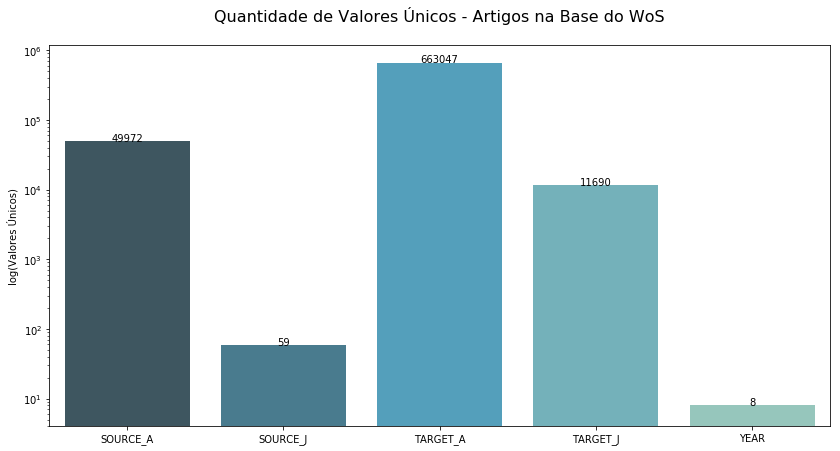

In [26]:
plt.figure(figsize=(14, 7))

cols = df_citations.columns

uniques = [len(df_citations[col].unique()) for col in cols]
ax = sns.barplot(cols, uniques, log=True, palette="GnBu_d")
ax.set(ylabel='log(Valores Únicos)', title='Quantidade de Valores Únicos - Artigos na Base do WoS\n')
ax.title.set_size(16)
for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.01, uniq, ha="center")

## Valores Mais Frequentes

In [27]:
def plot_top10(col, ascending=False, op='freq'):
    plt.figure(figsize=(18,6))

    counts = pd.value_counts(df_citations[col].values, ascending=ascending)[0:10]
    indx = counts.index
    counts.reset_index(drop=True, inplace=True)

    ax = sns.barplot(counts.index, counts.values, log=True, palette="GnBu_d")

    if col[-1] == 'A':
        ax.set_xticklabels((i.split('WOS:')[1] for i in indx), rotation=0)
    else:
        ax.set_xticklabels(indx, rotation=0)

    ax.set_xlabel('ID do ' +  str(col) + '\n')
    ax.set_ylabel("log(Quantidade)")
    ax.set_title("Valores Mais Frequentes de " + str(col) + ' - Base do WoS')
    ax.title.set_size(16)
    
    if op == 'count':
        for p, vals in zip(ax.patches, [val  for val in counts.values]):
            ax.text(p.get_x() + p.get_width()/2., p.get_height() + 0.01, vals, ha="center")
    else:
        for p, vals in zip(ax.patches, [round(100*val/len(df_citations),4) for val in counts.values]):
            ax.text(p.get_x() + p.get_width()/2., p.get_height() + 0.01, '{}%'.format(vals), ha="center") 

### Os artigos que mais citam

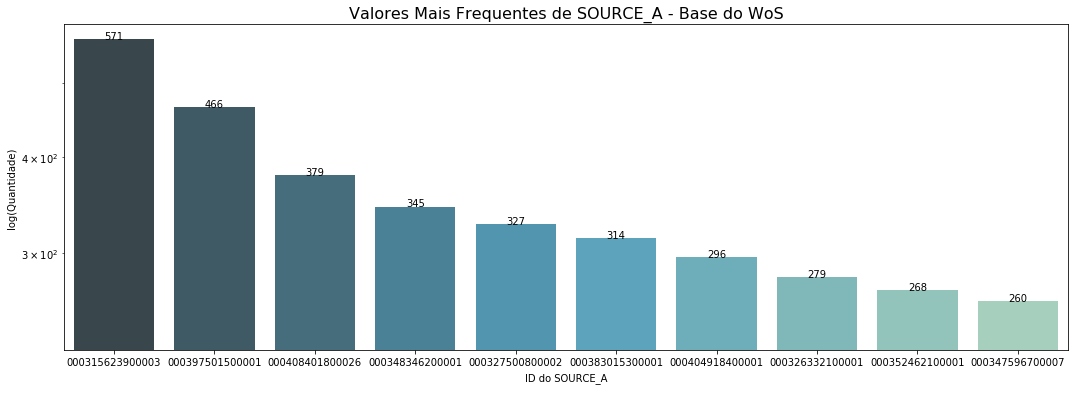

In [28]:
plot_top10('SOURCE_A', op='count')

In [29]:
k = 1
for i in list(pd.value_counts(df_citations['SOURCE_A'].values, ascending=False)[0:10].index):
    print(str(k) + ' - ' + list(articles_cit[articles_cit['ID_WOS'] == i].TITLE)[0])
    issn = list(df_citations[df_citations['SOURCE_A'] == i].SOURCE_J)[0]
    print('Publicado por: ' + list(journals_cit[journals_cit.index == issn].TITLE)[0] + '\n')
    k = k + 1

1 - Biometrika highlights from volume 28 onwards
Publicado por: BIOMETRIKA

2 - SheddomeDB: the ectodomain shedding database for membrane-bound shed markers
Publicado por: BMC BIOINFORMATICS

3 - Model of vascular desmoplastic multispecies tumor growth
Publicado por: JOURNAL OF THEORETICAL BIOLOGY

4 - FOUNDATIONS FOR MODELING THE DYNAMICS OF GENE REGULATORY NETWORKS: A MULTILEVEL-PERSPECTIVE REVIEW
Publicado por: Journal of Bioinformatics and Computational Biology

5 - A comprehensive map of the influenza A virus replication cycle
Publicado por: BMC Systems Biology

6 - Toward an Integration of Deep Learning and Neuroscience
Publicado por: Frontiers in Computational Neuroscience

7 - Gene expression profiles and signaling mechanisms in alpha(2B)-adrenoceptor-evoked proliferation of vascular smooth muscle cells
Publicado por: BMC Systems Biology

8 - Physical principles for scalable neural recording
Publicado por: Frontiers in Computational Neuroscience

9 - State-dependencies of learn

### Os periódicos que mais citam

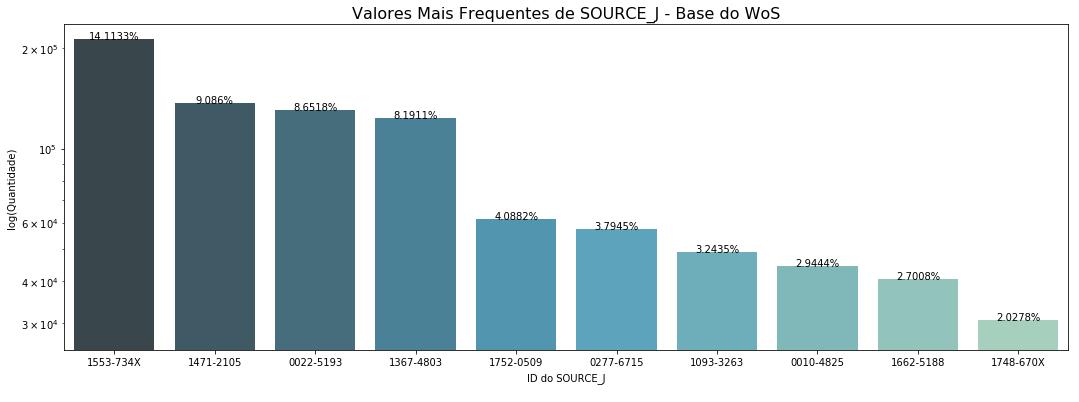

In [30]:
plot_top10('SOURCE_J', op='freq')

In [31]:
k = 1
for i in list(pd.value_counts(df_citations['SOURCE_J'].values, ascending=False)[0:10].index):
    print(str(k) + ' - ' + list(journals_cit[journals_cit.index == i].TITLE)[0])
    k = k + 1

1 - PLoS Computational Biology
2 - BMC BIOINFORMATICS
3 - JOURNAL OF THEORETICAL BIOLOGY
4 - BIOINFORMATICS
5 - BMC Systems Biology
6 - STATISTICS IN MEDICINE
7 - JOURNAL OF MOLECULAR GRAPHICS & MODELLING
8 - COMPUTERS IN BIOLOGY AND MEDICINE
9 - Frontiers in Computational Neuroscience
10 - Computational and Mathematical Methods in Medicine


### Os artigos mais citados

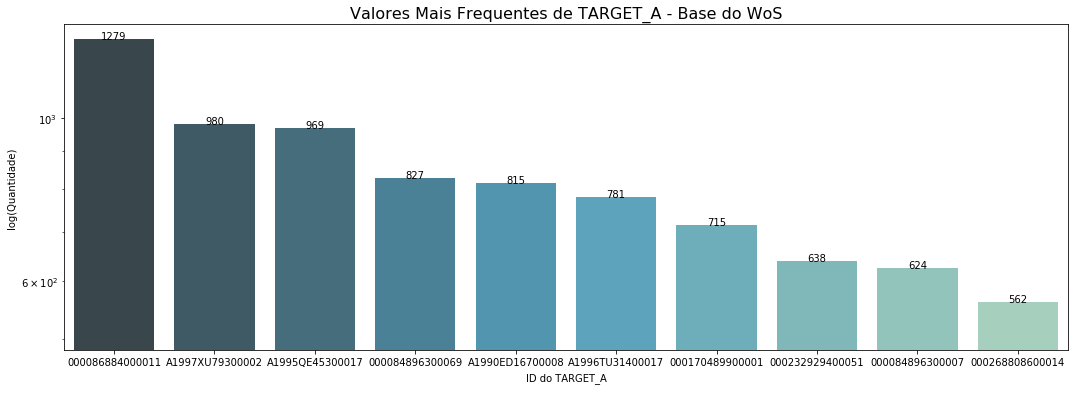

In [32]:
plot_top10('TARGET_A', op='count')

In [33]:
k = 1
for i in list(pd.value_counts(df_citations['TARGET_A'].values, ascending=False)[0:10].index):
    print(str(k) + ' - ' + list(articles_cit[articles_cit['ID_WOS'] == i].TITLE)[0])
    issn = list(df_citations[df_citations['TARGET_A'] == i].TARGET_J)[0]
    j = journals_cit[journals_cit.index == issn]
    print('Publicado por: ' + list(j.TITLE)[0] + '\n')
    k = k + 1

1 - Gene Ontology: tool for the unification of biology
Publicado por: NATURE GENETICS

2 - Gapped BLAST and PSI-BLAST: a new generation of protein database search programs
Publicado por: NUCLEIC ACIDS RESEARCH

3 - CONTROLLING THE FALSE DISCOVERY RATE - A PRACTICAL AND POWERFUL APPROACH TO MULTIPLE TESTING
Publicado por: JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-METHODOLOGICAL

4 - The Protein Data Bank
Publicado por: NUCLEIC ACIDS RESEARCH

5 - BASIC LOCAL ALIGNMENT SEARCH TOOL
Publicado por: JOURNAL OF MOLECULAR BIOLOGY

6 - Regression shrinkage and selection via the Lasso
Publicado por: JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-METHODOLOGICAL

7 - Random forests
Publicado por: MACHINE LEARNING

8 - Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles
Publicado por: PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA

9 - KEGG: Kyoto Encyclopedia of Genes and Genomes
Publicado por: NUCLEI

### Os periódicos mais citados

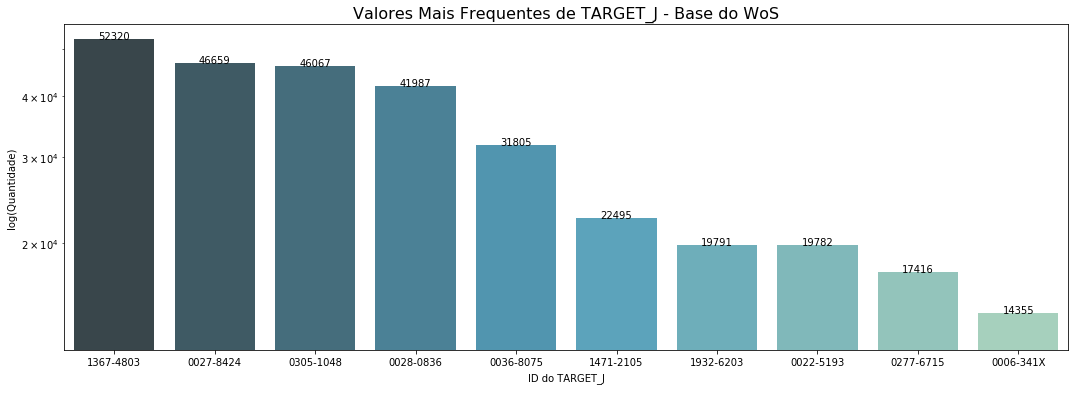

In [34]:
plot_top10('TARGET_J', op='count')

In [35]:
k = 1
for i in list(pd.value_counts(df_citations['TARGET_J'].values, ascending=False)[0:10].index):
    print(str(k) + ' - ' + list(journals_cit[journals_cit.index == i].TITLE)[0])
    k = k + 1

1 - BIOINFORMATICS
2 - PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA
3 - NUCLEIC ACIDS RESEARCH
4 - NATURE
5 - SCIENCE
6 - BMC BIOINFORMATICS
7 - PLOS ONE
8 - JOURNAL OF THEORETICAL BIOLOGY
9 - STATISTICS IN MEDICINE
10 - BIOMETRICS


### Quantidade de citações por ano

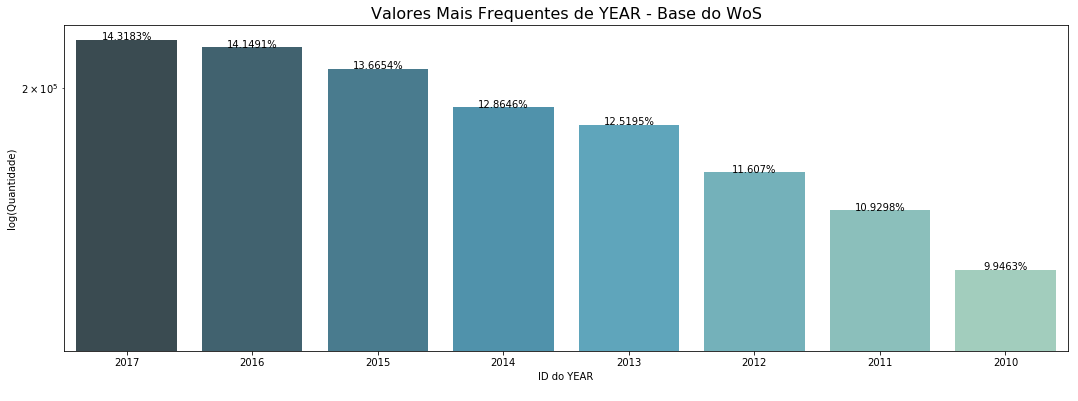

In [36]:
plot_top10('YEAR', op='freq')

## A Rede de Citações (Periódicos)

https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf

http://snap.stanford.edu/class/cs224w-2012/nx_tutorial.pdf

In [37]:
# Para usar no Gephi
#df_citations.to_csv('outputs/citations_gephi.csv', columns=['SOURCE_J', 'TARGET_J'], index=0,header=['Source', 'Target'])

A figura a seguir foi gerado usando o Gephi. A cor dos nós corresponde a sua classe de modualridade e o tamanho é proporcional ao seu grau de entrada. Foram identificadas 6 classes.

![](Figuras/FIG5.png)

### Gerando o grafo

In [38]:
G = nx.DiGraph()

In [39]:
i = list(df_citations.SOURCE_J)
j = list(df_citations.TARGET_J)

edges = []
for k in range(len(df_citations)):
    edges.append((i[k], j[k]))

In [40]:
print('Quantidade total de arestas (sem peso): ' + str(len(edges)))

Quantidade total de arestas (sem peso): 1508204


In [41]:
# Grafo direcionado ponderado pela quantidade de arestas do Journal_i para o Journal_j
G = nx.DiGraph((i, j, {'weight': v}) for (i, j), v in Counter(edges).items())

In [42]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 11690
Number of edges: 105795
Average in degree:   9.0500
Average out degree:   9.0500


In [43]:
# Matriz de Adjacências
M = nx.to_scipy_sparse_matrix(G)

### Distribuição do grau de entrada

https://gist.github.com/yamaguchiyuto/504eb5482fc73f046f6b

In [44]:
def plot_degree_distribution(data):
    plt.plot(range(len(data)),data,'bo')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Freq')
    plt.xlabel('in-Degree')
    plt.title('Distribuição do Grau de Entrada')
    plt.show()

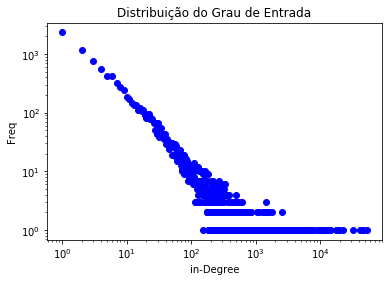

In [45]:
in_degrees = M.sum(0).A[0]
in_degree_distribution = np.bincount(in_degrees)
plot_degree_distribution(in_degree_distribution)

### Análise de modularidade

A modularidade irá nos ajudar a identificar as comunidades (clusters) de periódicos, com base em seu grau de citação.

In [46]:
df_modularity = pd.read_csv('outputs/gephi_info.csv', index_col=0, usecols=['Id','modularity_class'])

In [60]:
colors_class = ["#b86ce4", # 4
                "#51bf10",  # 5
                "#17beff", # 0
                "#e37212", # 3
                "#27805f", # 2
                "#fc416e" # 1
               ]
#sns.set_palette(colors_class)
#sns.palplot(sns.color_palette())

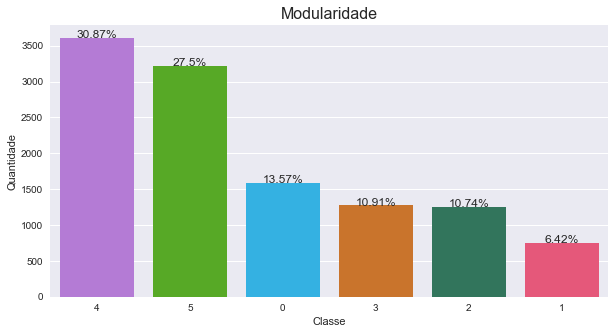

In [61]:
plt.figure(figsize=(10,5))

counts = pd.value_counts(df_modularity['modularity_class'].values, ascending=True)

sns.set(style="darkgrid")
ax = sns.countplot(x="modularity_class", data=df_modularity, palette=colors_class, order=list(counts.index)[::-1])

ax.set_xlabel('Classe')
ax.set_ylabel("Quantidade")
ax.set_title("Modularidade")
ax.title.set_size(16)

for p, vals in zip(ax.patches, [round(100*val/len(df_modularity),2) for val in counts.values[::-1]]):
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 0.01, '{}%'.format(vals), ha="center") 

In [49]:
# Informações coletadas do Gephi
df_info_gephi = pd.read_csv('outputs/gephi_info.csv', index_col=0)
df_info_gephi.head()

,Label,timeset,indegree,outdegree,degree,weighted indegree,weighted outdegree,weighted degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class,componentnumber,strongcompnum,eigencentrality,clustering
Id,,,,,,,,,,,,,,,,,
1553-734X,NaN,NaN,55,4839,4894,12190,212857,225047,3,0.62269,0.704009,51427.108182,1,0,11601,0.965064,0.003474
0305-1048,NaN,NaN,57,0,57,46067,0,46067,0,0.00000,0.000000,0.000000,0,0,1325,0.992729,0.591479
1932-6203,NaN,NaN,58,0,58,19791,0,19791,0,0.00000,0.000000,0.000000,0,0,8322,0.999688,0.578342
0969-2126,NaN,NaN,34,0,34,1968,0,1968,0,0.00000,0.000000,0.000000,0,0,5023,0.637201,0.748663
0907-4449,NaN,NaN,29,0,29,767,0,767,0,0.00000,0.000000,0.000000,2,0,1324,0.549663,0.788177


In [50]:
for i in range(max(df_modularity['modularity_class'])):
    globals()['class_%s' % i] = df_info_gephi[df_info_gephi.modularity_class == i]

In [76]:
def plot_mod_boxplot(column, name):
    data = []
    colors = ["#17beff", "#fc416e", "#27805f", "#e37212", "#b86ce4", "#51bf10"]
    for i in range(max(df_modularity['modularity_class'])+1):
        globals()['trace_%s' % i] = go.Box(
            y=list(df_info_gephi[df_info_gephi.modularity_class == i][column]),
            name='Classe ' + str(i),
            boxpoints='suspectedoutliers',
            jitter=0.5,
            whiskerwidth=0.2,
            line=dict(width=1),
            marker = dict(color = colors[i], size=4)
        )
        data.append(globals()['trace_%s' % i])

    layout = go.Layout(
        width=950,
        height=500,
        title='MATHEMATICAL & COMPUTATIONAL BIOLOGY (Modularidade)',
        xaxis=dict(title='Classe (Modularidade)', showticklabels=True),
        yaxis=dict(title=name),
        showlegend=False
        )

    fig = go.Figure(data=data, layout=layout)
    return offline.iplot(fig, filename='modularity_boxplot_eig')


#### Comparando o Eigenfactor das classes

In [77]:
plot_mod_boxplot('eigencentrality',' Eigenfactor')

In [78]:
plot_mod_boxplot('indegree',' Grau de Entrada')

### Reciprocidade

In [56]:
journals = list(set(set(df_citations.SOURCE_J) | set(df_citations.TARGET_J)))

In [57]:
R = pd.DataFrame(index=journals, columns=[str(i) for i in range(2010,2018)] )

In [390]:
for year in range(2010,2018):
    for i in journals:
        r_i = 0
        for j in journals:
            cit_ij = len(df_citations[(df_citations.SOURCE_J == i) & (df_citations.TARGET_J == j) &(df_citations.YEAR == year)])
            cit_ji = len(df_citations[(df_citations.SOURCE_J == j) & (df_citations.TARGET_J == i) &(df_citations.YEAR == year)])
            r = min(cit_ij,cit_ji)
            r_i = r_i + r
        k_i_out = len(df_citations[(df_citations.SOURCE_J == i) &(df_citations.YEAR == year)])
        R_i = r_i/k_i_out
        R[str(i)].loc[i] = R_I

In [ ]:
R.head()

In [ ]:
data = []
for i in range(2010,2018):
    globals()['trace_%s' % i] = go.Box(
        y=list(R[str(i)]),
        name=str(i),
        boxpoints='suspectedoutliers',
        jitter=0.5,
        whiskerwidth=0.2,
        line=dict(width=1),
        marker = dict(size=4)
    )
    data.append(globals()['trace_%s' % i])

layout = go.Layout(
    width=950,
    height=500,
    title='MATHEMATICAL & COMPUTATIONAL BIOLOGY (Modularidade)',
    xaxis=dict(title='Classe (Modularidade)', showticklabels=True),
    yaxis=dict(title='Ano'),
    showlegend=False
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='modularity_boxplot_eig')